# Laboration maskininlärning AI21


## 2. Disease prediction
### 2.0 - EDA uppvärmning


In [241]:
import sys
stdout = sys.stdout # Löser problemet med att print inte alltid skrivs ut 
# https://stackoverflow.com/questions/25494182/print-not-showing-in-ipython-notebook

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from joblib import dump

sys.stdout = stdout

In [3]:
# Läs in dataset
df_cardio_raw = pd.read_csv("Data/cardio_train.csv", sep=";").set_index("id")
df_cardio_raw["age_years"] = (df_cardio_raw["age"] / 365.25)

df_cardio_raw.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
id,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.357290
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.381246
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.627652
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.249144
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.841205



#### a) Hur många är positiva för hjärt-kärlsjukdom och hur många är negativa?


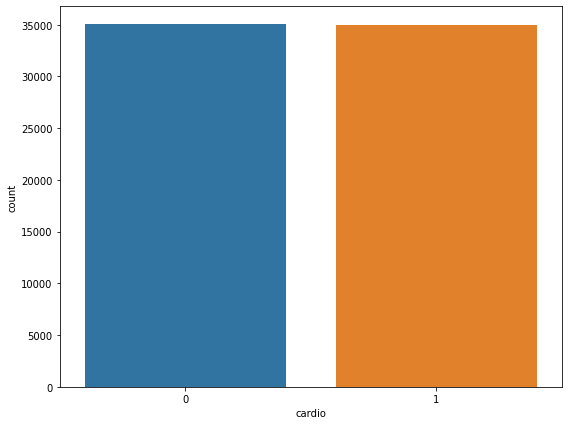

In [16]:
plt.figure(figsize = [9, 7])
sns.countplot(x=df_cardio_raw["cardio"]);

Lika många i båda grupperna


#### b) Hur stor andel har normala, över normala och långt över normala kolesterolvärden? Rita ett tårtdiagram.


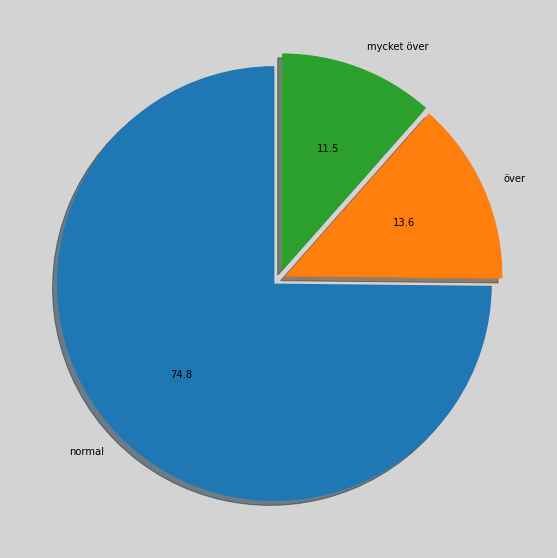

In [7]:

fig  = plt.figure(figsize = [10, 10])
plt.pie(df_cardio_raw["cholesterol"].value_counts(), labels = ("normal", "över", "mycket över"), autopct="%.1f", startangle=90, explode=(0.03, 0.03, 0.04), shadow=True, )

fig.set_facecolor('lightgrey')


#### c) Hur ser åldersfördelningen ut? Rita ett histogram.


In [13]:
def histogram(df, feature, binwidth=1 ):
    bin_range = (np.floor(df[feature].min()), np.floor(df[feature].max())) 
    bin_range = (bin_range[0] - bin_range[0] % binwidth, bin_range[1] - bin_range[1] % binwidth + binwidth)
    
    print("bin_range:", bin_range )
    plt.figure(figsize = [10, 10])
    sns.histplot(df, x=feature, binrange=bin_range,  binwidth=binwidth)


bin_range: (29.0, 65.0)


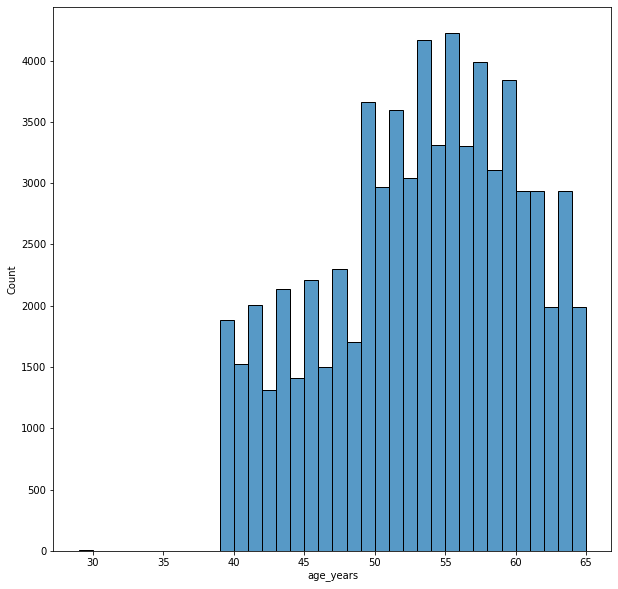

In [14]:
histogram(df_cardio_raw, "age_years")

Märkligt utseende där var annat år verkar vara större och vart annant lägre. Hittar dock inte att det skulle vara något fel.

#### d) Hur stor andel röker?


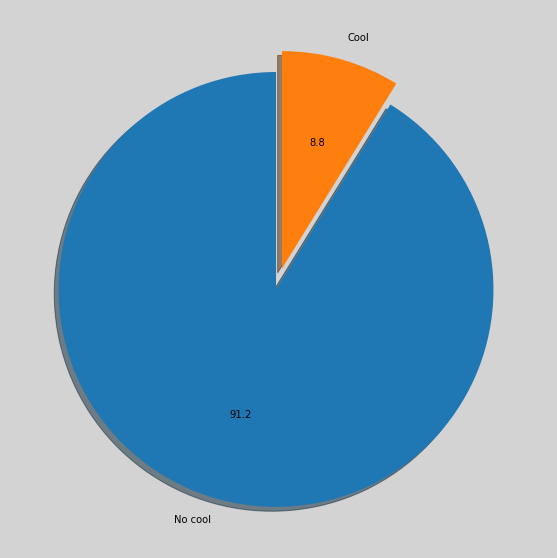

In [17]:
fig  = plt.figure(figsize = [10, 10])
plt.pie(df_cardio_raw["smoke"].value_counts(), labels = ("No cool", "Cool"), autopct="%.1f", startangle=90, explode=(0.05, 0.05), shadow=True, )

fig.set_facecolor('lightgrey')


😎 8,8 % 🚬

🤓 91,2 % 🚭


#### e) Hur ser viktfördelningen ut? Rita lämpligt diagram.


bin_range: (10.0, 205.0)


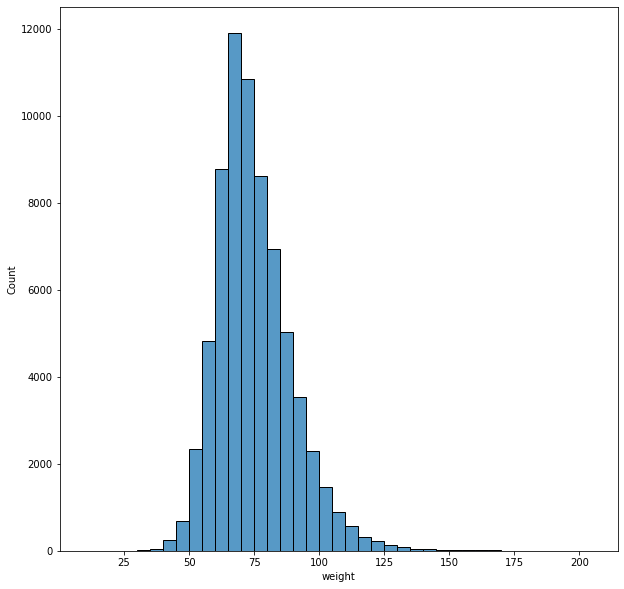

In [19]:
histogram(df_cardio_raw, "weight", 5)


#### f) Hur ser längdfördelningen ut? Rita lämpligt diagram.


bin_range: (55.0, 255.0)


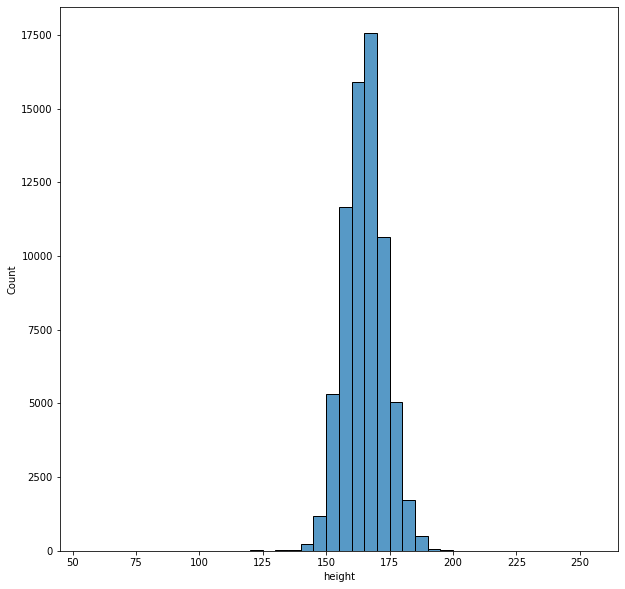

In [21]:
histogram(df_cardio_raw, "height", 5)


#### g) Hur stor andel av kvinnor respektive män har hjärt-kärlsjukdom? Rita lämpligt diagram


In [156]:
# Katigorisera kön
df_cardio = df_cardio_raw.copy()
df_cardio.loc[df_cardio["gender"] == 1, "gender"] = "female"
df_cardio.loc[df_cardio["gender"] == 2, "gender"] = "male"


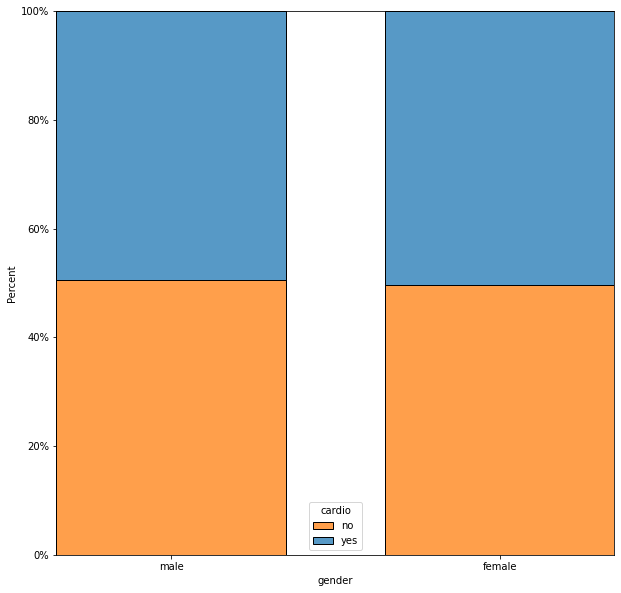

In [157]:
fig  = plt.figure(figsize = [10, 10])
ax = sns.histplot(df_cardio, x="gender", hue= "cardio", stat="percent", multiple="fill", shrink=0.7 , )
ax.xaxis.set
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(["no", "yes"], title="cardio");


### 2.1.0 - Feature engineering BMI



In [158]:
# BMI min och max
# Ingen aning om det är rimliga värden jag är ingen läkare. Det är inget för mig att försöka mig på.

height_min = 130
height_max = 220

weight_min = 30
weight_max = 200

bmi_min = 15 
bmi_max = 50

In [159]:
# Rensa data
df_cardio = df_cardio.query("height > @height_min and height < @height_max and " + 
                            "weight > @weight_min and weight < @weight_max")
                            

In [160]:
# BMI = massa / längd^2
df_cardio["bmi"] = df_cardio["weight"] / (df_cardio["height"]/100)**2 
df_cardio

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
id,,,,,,,,,,,,,,
0,18393,male,168,62.0,110,80,1,1,0,0,1,0,50.357290,21.967120
1,20228,female,156,85.0,140,90,3,1,0,0,1,1,55.381246,34.927679
2,18857,female,165,64.0,130,70,3,1,0,0,0,1,51.627652,23.507805
3,17623,male,169,82.0,150,100,1,1,0,0,1,1,48.249144,28.710479
4,17474,female,156,56.0,100,60,1,1,0,0,0,0,47.841205,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,male,168,76.0,120,80,1,1,1,0,1,0,52.676249,26.927438
99995,22601,female,158,126.0,140,90,2,2,0,0,1,1,61.878166,50.472681
99996,19066,male,183,105.0,180,90,3,1,0,1,0,1,52.199863,31.353579


In [161]:
# Rensa data
df_cardio = df_cardio.query("bmi > @bmi_min and bmi < @bmi_max")

In [162]:
# Skapa kategoriska BMI
df_cardio["bmi_cat"] = pd.cut(df_cardio["bmi"], bins= [bmi_min, 25, 30, 35, 40, bmi_max], 
        labels=["Normal range", "Overweight", "Obese (Class I)", "Obese (Class II)", "Obese (Class III)"], ordered=True)

df_cardio

C:\Users\ErikLarsson-AIU21GBG\AppData\Local\Temp\ipykernel_3948\27251570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cardio["bmi_cat"] = pd.cut(df_cardio["bmi"], bins= [bmi_min, 25, 30, 35, 40, bmi_max],


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bmi_cat
id,,,,,,,,,,,,,,,
0,18393,male,168,62.0,110,80,1,1,0,0,1,0,50.357290,21.967120,Normal range
1,20228,female,156,85.0,140,90,3,1,0,0,1,1,55.381246,34.927679,Obese (Class I)
2,18857,female,165,64.0,130,70,3,1,0,0,0,1,51.627652,23.507805,Normal range
3,17623,male,169,82.0,150,100,1,1,0,0,1,1,48.249144,28.710479,Overweight
4,17474,female,156,56.0,100,60,1,1,0,0,0,0,47.841205,23.011177,Normal range
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992,21074,female,165,80.0,150,80,1,1,0,0,1,1,57.697467,29.384757,Overweight
99993,19240,male,168,76.0,120,80,1,1,1,0,1,0,52.676249,26.927438,Overweight
99996,19066,male,183,105.0,180,90,3,1,0,1,0,1,52.199863,31.353579,Obese (Class I)


### 2.1.1 - Feature engineering blodtryck

In [163]:
# Blodtryck min och max

# Systoliskt blodtryck
ap_hi_min = 40
ap_hi_max = 250

# Diastoliskt blodtryck
ap_lo_min = 20
ap_lo_max = 190


In [165]:
df_cardio = df_cardio.query("ap_lo > @ap_lo_min and ap_lo < @ap_lo_max and " +
                "ap_hi > @ap_hi_min and ap_hi < @ap_hi_max")
df_cardio

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bmi_cat
id,,,,,,,,,,,,,,,
0,18393,male,168,62.0,110,80,1,1,0,0,1,0,50.357290,21.967120,Normal range
1,20228,female,156,85.0,140,90,3,1,0,0,1,1,55.381246,34.927679,Obese (Class I)
2,18857,female,165,64.0,130,70,3,1,0,0,0,1,51.627652,23.507805,Normal range
3,17623,male,169,82.0,150,100,1,1,0,0,1,1,48.249144,28.710479,Overweight
4,17474,female,156,56.0,100,60,1,1,0,0,0,0,47.841205,23.011177,Normal range
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992,21074,female,165,80.0,150,80,1,1,0,0,1,1,57.697467,29.384757,Overweight
99993,19240,male,168,76.0,120,80,1,1,1,0,1,0,52.676249,26.927438,Overweight
99996,19066,male,183,105.0,180,90,3,1,0,1,0,1,52.199863,31.353579,Obese (Class I)


In [166]:
def blood_pressure_range(row):
    ap_hi = row["ap_hi"]
    ap_lo = row["ap_lo"]

    if ap_hi < 120 and ap_lo < 80:
        return "Helthy"
    elif ap_hi < 130 and ap_lo < 80:
        return "Elevated"
    elif ap_hi < 140 and ap_lo < 90:
        return "Stage 1 hypertension"
    elif ap_hi < 180 and ap_lo < 120:
        return "Stage 2 hypertension"
    else:
        return "Hypertension crisis"


In [167]:
df_cardio["ap_cat"] = pd.Categorical(df_cardio.apply(lambda row: blood_pressure_range(row), axis=1), ["Helthy", "Elevated", "Stage 1 hypertension", "Stage 2 hypertension", "Hypertension crisis"])


### 2.2.0 - Visualiseringar andel sjukdomar


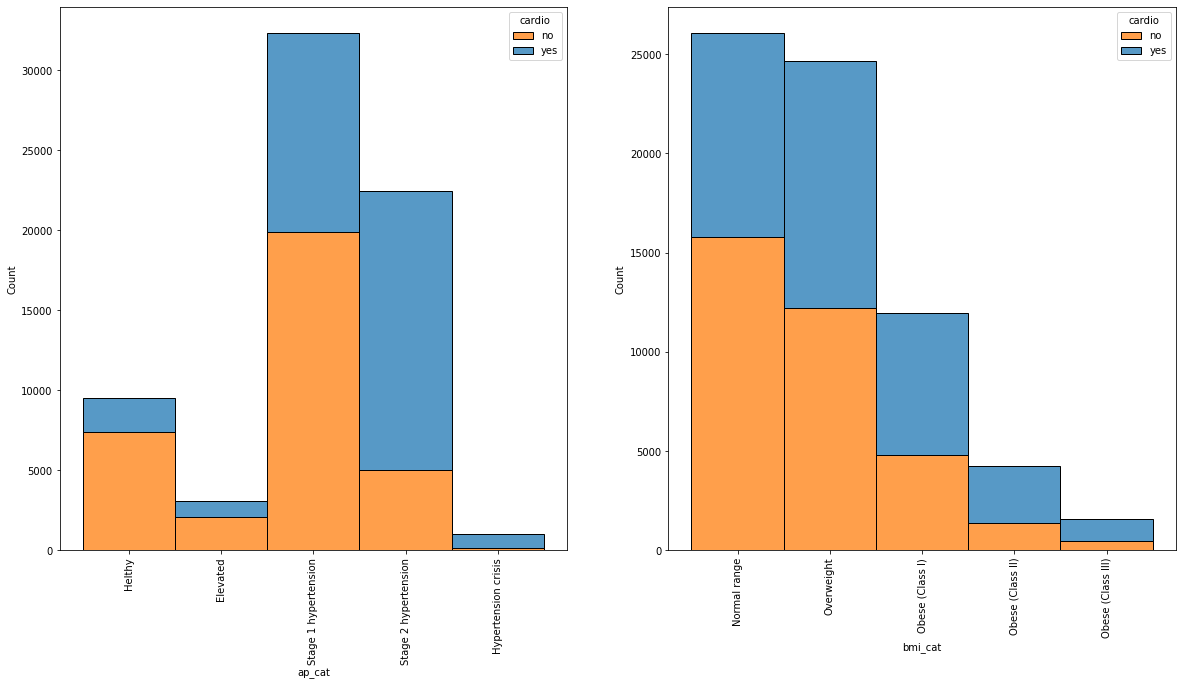

In [168]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.histplot(df_cardio, x="ap_cat", hue="cardio", multiple="stack", hue_order=(1, 0))
plt.xticks(rotation=90)
plt.legend(["no", "yes"], title="cardio")

plt.subplot(1, 2, 2)
sns.histplot(df_cardio, x="bmi_cat", hue="cardio", multiple="stack", hue_order=(1, 0))
plt.xticks(rotation=90)
plt.legend(["no", "yes"], title="cardio");

### 2.2.1 - Visualiseringar korrelation

,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
age,1.000000,-0.085979,0.055988,0.208885,0.153142,0.155334,0.099107,-0.048052,-0.029049,-0.010448,0.239944,1.000000,0.105503
height,-0.085979,1.000000,0.324744,0.019285,0.036366,-0.055223,-0.020606,0.196696,0.098856,-0.009392,-0.011540,-0.085979,-0.192687
weight,0.055988,0.324744,1.000000,0.267986,0.247802,0.141304,0.104153,0.069805,0.069547,-0.018555,0.180751,0.055988,0.860978
ap_hi,0.208885,0.019285,0.267986,1.000000,0.697074,0.193648,0.091410,0.027214,0.032570,-0.001200,0.425382,0.208885,0.267553
ap_lo,0.153142,0.036366,0.247802,0.697074,1.000000,0.158375,0.075065,0.025014,0.043051,-0.000029,0.335105,0.153142,0.237780
cholesterol,0.155334,-0.055223,0.141304,0.193648,0.158375,1.000000,0.450284,0.010069,0.036014,0.009162,0.221542,0.155334,0.174727
gluc,0.099107,-0.020606,0.104153,0.091410,0.075065,0.450284,1.000000,-0.005553,0.011072,-0.007582,0.089224,0.099107,0.117861
smoke,-0.048052,0.196696,0.069805,0.027214,0.025014,0.010069,-0.005553,1.000000,0.340164,0.025258,-0.016167,-0.048052,-0.033393
alco,-0.029049,0.098856,0.069547,0.032570,0.043051,0.036014,0.011072,0.340164,1.000000,0.025001,-0.007982,-0.029049,0.018322
active,-0.010448,-0.009392,-0.018555,-0.001200,-0.000029,0.009162,-0.007582,0.025258,0.025001,1.000000,-0.037381,-0.010448,-0.014784


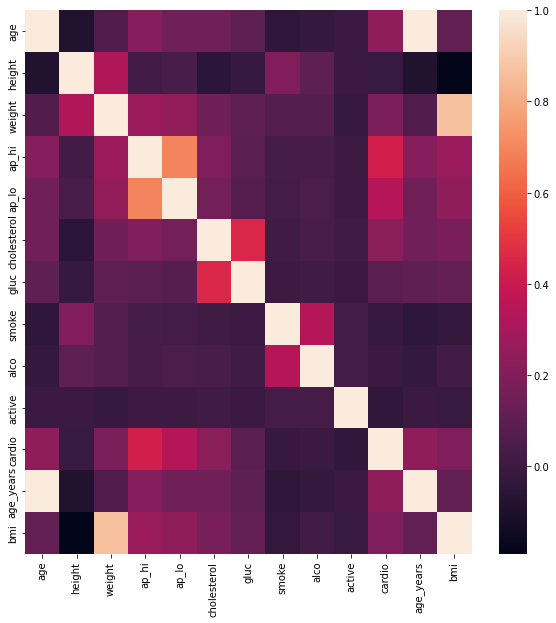

In [169]:
plt.figure(figsize=(10,10))
sns.heatmap(df_cardio.corr(), )
df_cardio.corr()

Korreletion stor positiv
- 1.000000: "age" - "age_years". De är ju linjärt beroende så det stämmer.
- 0.860978: "bmi" - "weight". Det är ju täljaren i formeln för BMI.
- 0.697074: "ap_lo" - "ap_hi". Inses lätt att de bör hänga ihop.	

Korrelation stor negativ
- -0.192687: "bmi" - "height". Det är ju i nämnaren på formeln för BMI så det är rimligt. Kvadraten gör att korrelationen inte blir lika stor som för weight.


### 2.3 - Skapa två dataset


In [174]:
df_cardio_1 = df_cardio.copy()
df_cardio_1.drop(["age", "ap_hi", "ap_lo", "height", "weight", "bmi"], inplace=True, axis=1)
df_cardio_1 = pd.get_dummies(df_cardio_1, columns=["gender", "ap_cat", "bmi_cat"], drop_first=True)
df_cardio_1

,cholesterol,gluc,smoke,alco,active,cardio,age_years,gender_male,ap_cat_Elevated,ap_cat_Stage 1 hypertension,ap_cat_Stage 2 hypertension,ap_cat_Hypertension crisis,bmi_cat_Overweight,bmi_cat_Obese (Class I),bmi_cat_Obese (Class II),bmi_cat_Obese (Class III)
id,,,,,,,,,,,,,,,,
0,1,1,0,0,1,0,50.357290,1,0,1,0,0,0,0,0,0
1,3,1,0,0,1,1,55.381246,0,0,0,1,0,0,1,0,0
2,3,1,0,0,0,1,51.627652,0,0,1,0,0,0,0,0,0
3,1,1,0,0,1,1,48.249144,1,0,0,1,0,1,0,0,0
4,1,1,0,0,0,0,47.841205,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992,1,1,0,0,1,1,57.697467,0,0,0,1,0,1,0,0,0
99993,1,1,1,0,1,0,52.676249,1,0,1,0,0,1,0,0,0
99996,3,1,0,1,0,1,52.199863,1,0,0,0,1,0,1,0,0


In [178]:
df_cardio_2 = df_cardio.copy()
df_cardio_2.drop(["age", "ap_cat", "bmi_cat", "height", "weight"], inplace=True, axis=1)
df_cardio_2 = pd.get_dummies(df_cardio_2, columns=["gender"], drop_first=True)
df_cardio_2

,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,gender_male
id,,,,,,,,,,,
0,110,80,1,1,0,0,1,0,50.357290,21.967120,1
1,140,90,3,1,0,0,1,1,55.381246,34.927679,0
2,130,70,3,1,0,0,0,1,51.627652,23.507805,0
3,150,100,1,1,0,0,1,1,48.249144,28.710479,1
4,100,60,1,1,0,0,0,0,47.841205,23.011177,0
...,...,...,...,...,...,...,...,...,...,...,...
99992,150,80,1,1,0,0,1,1,57.697467,29.384757,0
99993,120,80,1,1,1,0,1,0,52.676249,26.927438,1
99996,180,90,3,1,0,1,0,1,52.199863,31.353579,1


### 2.4 - Välja modell

In [183]:
X_1_train_val, X_1_test, y_1_train_val, y_1_test = train_test_split(df_cardio_1.drop("cardio", axis=1), df_cardio_1["cardio"], test_size = 0.33, random_state = 42)
X_1_train, X_1_val, y_1_train, y_1_val = train_test_split(X_1_train_val, y_1_train_val, test_size = 0.5, random_state = 42)

X_2_train_val, X_2_test, y_2_train_val, y_2_test = train_test_split(df_cardio_2.drop("cardio", axis=1), df_cardio_2["cardio"], test_size = 0.33, random_state = 42)
X_2_train, X_2_val, y_2_train, y_2_val = train_test_split(X_2_train_val, y_2_train_val, test_size = 0.5, random_state = 42)

X_1_train.shape, X_1_val.shape, X_1_test.shape, y_1_train.shape, y_1_val.shape, y_1_test.shape

((22947, 15), (22948, 15), (22606, 15), (22947,), (22948,), (22606,))

In [211]:
def eval_model(y_true, y_pred):
    print(classification_report(y_true, y_pred), flush=True)
    
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot()

##### K goda grannar

In [218]:
pipe_KNN = Pipeline([("scaler", None), ("knn", KNeighborsClassifier())])

param_grid_KNN = {"knn__n_neighbors": list(range(1, 25, 1)), "scaler" : [MinMaxScaler(), StandardScaler()]}

classifier_KNN= GridSearchCV(
    estimator=pipe_KNN, param_grid=param_grid_KNN, cv=5, scoring="recall", verbose=3, n_jobs=-1)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Scaler StandardScaler() n 11
              precision    recall  f1-score   support

           0       0.70      0.72      0.71     11544
           1       0.71      0.69      0.70     11404

    accuracy                           0.70     22948
   macro avg       0.70      0.70      0.70     22948
weighted avg       0.70      0.70      0.70     22948



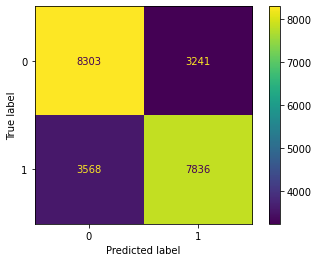

In [219]:
# KNN dataset 1
classifier_KNN.fit(X_1_train, y_1_train)

best_knn_scaler_1 = classifier_KNN.best_estimator_.get_params()["scaler"]
best_knn_n_1 = classifier_KNN.best_estimator_.get_params()['knn__n_neighbors']
print("Scaler",best_knn_scaler_1, "n", best_knn_n_1)
knn_y_1_pred = classifier_KNN.predict(X_1_val)

eval_model(y_1_val, knn_y_1_pred)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Scaler MinMaxScaler() n 17
              precision    recall  f1-score   support

           0       0.71      0.74      0.72     11544
           1       0.72      0.69      0.71     11404

    accuracy                           0.71     22948
   macro avg       0.71      0.71      0.71     22948
weighted avg       0.71      0.71      0.71     22948



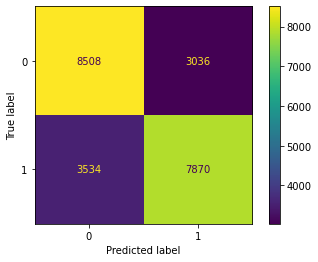

In [220]:
# KNN dataset 2
classifier_KNN.fit(X_2_train, y_2_train)

best_knn_scaler_2 = classifier_KNN.best_estimator_.get_params()["scaler"]
best_knn_n_2 = classifier_KNN.best_estimator_.get_params()['knn__n_neighbors']
print("Scaler",best_knn_scaler_2, "n", best_knn_n_2)
knn_y_2_pred = classifier_KNN.predict(X_2_val)

eval_model(y_2_val, knn_y_2_pred)


##### SVC


In [227]:
pipe_svc = Pipeline([("scaler", None), ("svc", SVC(random_state=42))])
cv = 3 # Valt för att få ner beräkningstiden som är lång och datasetet är ganska stort.

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Scaler StandardScaler()  criterion 2.0
              precision    recall  f1-score   support

           0       0.70      0.79      0.74     11544
           1       0.75      0.65      0.70     11404

    accuracy                           0.72     22948
   macro avg       0.72      0.72      0.72     22948
weighted avg       0.72      0.72      0.72     22948



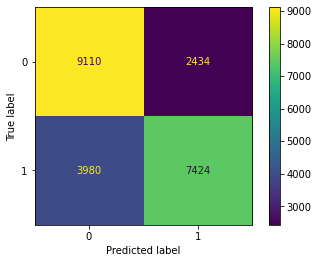

In [231]:
# SVC dataset 1
c_range_1 = np.linspace(0.1, 2, 20) 

param_grid_svc_1 = {"svc__C" : c_range_1, "scaler" : [MinMaxScaler(), StandardScaler()] }
classifier_svc_1 = GridSearchCV(
    estimator=pipe_svc, param_grid=param_grid_svc_1, cv=cv, scoring="recall", verbose=3, n_jobs=-1)

classifier_svc_1.fit(X_1_train, y_1_train)

best_svc_scaler_1 = classifier_svc_1.best_estimator_.get_params()["scaler"]
best_svc_C_1 = classifier_svc_1.best_estimator_.get_params()['svc__C']
print("Scaler", best_svc_scaler_1, " criterion", best_svc_C_1, flush=True)

svc_y_1_pred = classifier_svc_1.predict(X_1_val)

eval_model(y_1_val, svc_y_1_pred)


In [ ]:
# SVC dataset 2
c_range_2 =  list(range(5, 30, 1))

param_grid_svc_2 = {"svc__C" : c_range_2, "scaler" : [MinMaxScaler(), StandardScaler()] }
classifier_svc_2 = GridSearchCV(
    estimator=pipe_svc, param_grid=param_grid_svc_2, cv=cv, scoring="recall", verbose=3, n_jobs=-1)

classifier_svc_2.fit(X_2_train, y_2_train)

best_svc_scaler_2 = classifier_svc_2.best_estimator_.get_params()["scaler"]
best_svc_C_2 = classifier_svc_2.best_estimator_.get_params()['svc__C']
print("Scaler", best_svc_scaler_2, " criterion", best_svc_C_2, flush=True)

svc_y_2_pred = classifier_svc_2.predict(X_2_val)

eval_model(y_2_val, svc_y_2_pred)

Scaler MinMaxScaler()  criterion 24
              precision    recall  f1-score   support

           0       0.71      0.78      0.74     11544
           1       0.75      0.68      0.71     11404

    accuracy                           0.73     22948
   macro avg       0.73      0.73      0.73     22948
weighted avg       0.73      0.73      0.73     22948



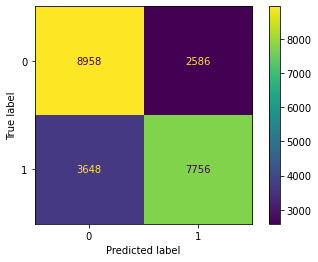

In [240]:
# Varför kommer inte dessa print med första gången?
print("Scaler", best_svc_scaler_2, " criterion", best_svc_C_2, flush=True)
eval_model(y_2_val, svc_y_2_pred)


##### Beslutsträd


In [233]:

pipe_tree = Pipeline([("scaler", None), ("tree", DecisionTreeClassifier())])

param_grid_tree = {"tree__criterion" : ["gini", "entropy"], "tree__max_depth" : list(range(1, 20, 1)), "scaler" : [MinMaxScaler(), StandardScaler()] }
classifier_tree = GridSearchCV(
    estimator=pipe_tree, param_grid=param_grid_tree, cv=5, scoring="recall", verbose=3, n_jobs=-1)


Fitting 5 folds for each of 76 candidates, totalling 380 fits
Scaler MinMaxScaler()  criterion entropy  max depth 9
              precision    recall  f1-score   support

           0       0.71      0.74      0.72     11544
           1       0.72      0.70      0.71     11404

    accuracy                           0.72     22948
   macro avg       0.72      0.72      0.72     22948
weighted avg       0.72      0.72      0.72     22948



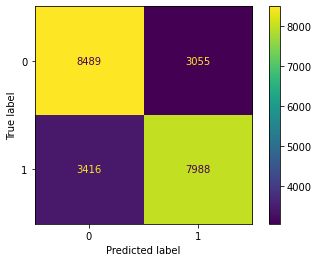

In [246]:
# Beslutsträd dataset 1
classifier_tree.fit(X_1_train, y_1_train)

best_tree_scaler_1 = classifier_tree.best_estimator_.get_params()["scaler"]
best_tree_criterion_1 = classifier_tree.best_estimator_.get_params()['tree__criterion']
best_tree_max_depth_1 = classifier_tree.best_estimator_.get_params()['tree__max_depth']

print("Scaler", best_tree_scaler_1, " criterion", best_tree_criterion_1, " max depth", best_tree_max_depth_1, flush=True)
tree_y_1_pred = classifier_tree.predict(X_1_val)

eval_model(y_1_val, tree_y_1_pred)


Fitting 5 folds for each of 76 candidates, totalling 380 fits
Scaler MinMaxScaler()  criterion entropy  max depth 4
              precision    recall  f1-score   support

           0       0.73      0.73      0.73     11544
           1       0.73      0.72      0.72     11404

    accuracy                           0.73     22948
   macro avg       0.73      0.73      0.73     22948
weighted avg       0.73      0.73      0.73     22948



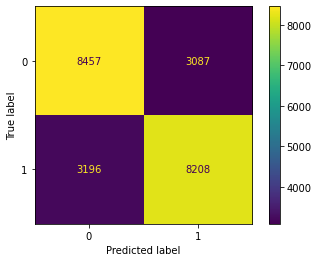

In [243]:
# Beslutsträd dataset 2
classifier_tree.fit(X_2_train, y_2_train)

best_tree_scaler_2 = classifier_tree.best_estimator_.get_params()["scaler"]
best_tree_criterion_2 = classifier_tree.best_estimator_.get_params()['tree__criterion']
best_tree_max_depth_2 = classifier_tree.best_estimator_.get_params()['tree__max_depth']

print("Scaler", best_tree_scaler_2, " criterion", best_tree_criterion_2, " max depth", best_tree_max_depth_2)
tree_y_2_pred = classifier_tree.predict(X_2_val)

eval_model(y_2_val, tree_y_2_pred)

#### Val
Beslutsträdet med det andra datasetet gav högst värde på recall, 0,72. Den gav också högst värde på f1, 0,72. Men skillnaden är inte så stor. 

Som bonus gick den väldigt fort att köra jämfört med de andra.
Så vi väljer den.

In [247]:
recall_vald = float(classification_report(y_2_val, tree_y_2_pred).split("\n")[3].split("    ")[4].strip())
recall_vald

0.72

In [248]:
df_cardio_vald = df_cardio_2
X_train_val_vald = X_2_train_val 
y_train_val_vald = y_2_train_val
X_test_vald = X_2_test
y_test_vald = y_2_test

In [249]:
clf_knn = Pipeline([("scaler", best_knn_scaler_2), ("knn", KNeighborsClassifier(n_neighbors=best_knn_n_2))])
clf_svc = Pipeline([("scaler", best_svc_scaler_2), ("svc", SVC(C=best_svc_C_2 , random_state=42, ))])
clf_tree = Pipeline([("scaler", best_tree_scaler_2), ("tree", DecisionTreeClassifier(criterion=best_tree_criterion_2, max_depth=best_tree_max_depth_2 ))])

model_vald = clf_tree


In [250]:
model_vald.fit(X_train_val_vald, y_train_val_vald)

model_vald_y_pred = model_vald.predict(X_test_vald)

              precision    recall  f1-score   support

           0       0.73      0.74      0.74     11536
           1       0.73      0.72      0.72     11070

    accuracy                           0.73     22606
   macro avg       0.73      0.73      0.73     22606
weighted avg       0.73      0.73      0.73     22606



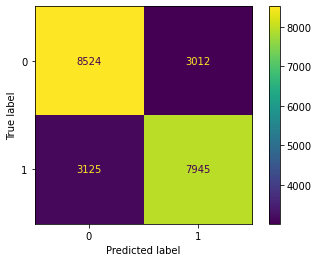

In [251]:
eval_model(y_test_vald, model_vald_y_pred)

Nästan samma resultat med mer data. Men kanske aningens bättre till och med.

### 2.5 Ensemble



              precision    recall  f1-score   support

           0       0.73      0.77      0.75     11536
           1       0.75      0.70      0.72     11070

    accuracy                           0.74     22606
   macro avg       0.74      0.73      0.73     22606
weighted avg       0.74      0.74      0.73     22606



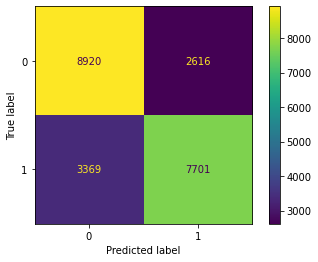

In [253]:
vote_clf = VotingClassifier([
    ("knn", clf_knn),
    ("svc", clf_svc),    
    ("tree", clf_tree)
    ] , 
     voting="hard")

vote_clf.fit(X_train_val_vald, y_train_val_vald)

vote_y_pred = vote_clf.predict(X_test_vald)

eval_model(y_test_vald, vote_y_pred)

Sammanvägda modellen gav aningen sämre resultatet än för den valda modellen. Men ingen stor skillnad.

### 2.6 Evalueringar

Se 2.4 och 2.5

### 2.7 "Deploy" - spara modell


In [254]:
df_cardio_train, df_cardio_test = train_test_split(df_cardio_vald, test_size=100 )
df_cardio_test.to_csv("test_samples.csv", index=True)

model_vald.fit(df_cardio_train.drop("cardio", axis=1), df_cardio_train["cardio"])
dump(model_vald, "model.pkl")

['model.pkl']